In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.utils as tg_utils
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from imblearn.over_sampling import SMOTE
from mpl_toolkits.mplot3d import Axes3D
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mpl_toolkits.basemap import Basemap
import requests
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

C:\Users\harsh\AppData\Local\Temp\ipykernel_17776\854447061.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [3]:
df.shape

(958524, 45)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [5]:
df.isnull().sum()

id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926


In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.239632e+06,16.100000,2.780000,0.053000,0.180000,2.459000e+06,59000.000000,2.020053e+07,0.092193,2.387835,...,1.462000e-07,6.095900e-06,3.619400e-05,5.755000e-05,2.573700e-05,2.340900e-08,2.768800e-09,1.110900e-04,1.794500e-05,0.518040
50%,2.479262e+06,16.900000,3.972000,0.079000,0.332000,2.459000e+06,59000.000000,2.020053e+07,0.145002,2.646969,...,2.271900e-07,8.688800e-06,6.642550e-05,1.047100e-04,4.900100e-05,4.359000e-08,4.638000e-09,2.230800e-04,3.501700e-05,0.566280
75%,3.752518e+06,17.714000,5.765000,0.190000,0.620000,2.459000e+06,59000.000000,2.020053e+07,0.200650,3.001932,...,6.583200e-07,1.591500e-05,1.609775e-04,3.114400e-04,1.718900e-04,1.196600e-07,1.124000e-08,8.139600e-04,9.775475e-05,0.613927
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


In [8]:
print("original shape: ", df.shape)

original shape:  (958524, 45)


In [9]:
df_clean = df.dropna(subset=['pha'])
print("shape after dropping rows with missing 'pha': ", df_clean.shape)

shape after dropping rows with missing 'pha':  (938603, 45)


In [10]:
drop_cols = ['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'orbit_id', 'epoch_cal', 'equinox', 'tp_cal']
df_clean = df_clean.drop(columns=drop_cols)
print("Shape after dropping columns:", df_clean.shape)

Shape after dropping columns: (938603, 35)


In [11]:
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid', 'epoch', 'epoch_mjd', 'albedo', 'diameter_sigma',
                  'om', 'w', 'ma', 'ad', 'n', 'tp', 'per', 'per_y', 'moid_ld', 'sigma_e', 'sigma_a', 'sigma_q',
                  'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms']
categorical_cols = ['neo', 'class']

In [12]:
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

In [13]:
print("\nMissing Values After Imputation:")
print(df_clean.isnull().sum())
print("\nCleaned Dataset Shape:", df_clean.shape)
print("\nCleaned Dataset Info:")
print(df_clean.info())


Missing Values After Imputation:
neo               0
pha               0
H                 0
diameter          0
albedo            0
diameter_sigma    0
epoch             0
epoch_mjd         0
e                 0
a                 0
q                 0
i                 0
om                0
w                 0
ma                0
ad                0
n                 0
tp                0
per               0
per_y             0
moid              0
moid_ld           0
sigma_e           0
sigma_a           0
sigma_q           0
sigma_i           0
sigma_om          0
sigma_w           0
sigma_ma          0
sigma_ad          0
sigma_n           0
sigma_tp          0
sigma_per         0
class             0
rms               0
dtype: int64

Cleaned Dataset Shape: (938603, 35)

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 938603 entries, 0 to 958523
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   ---

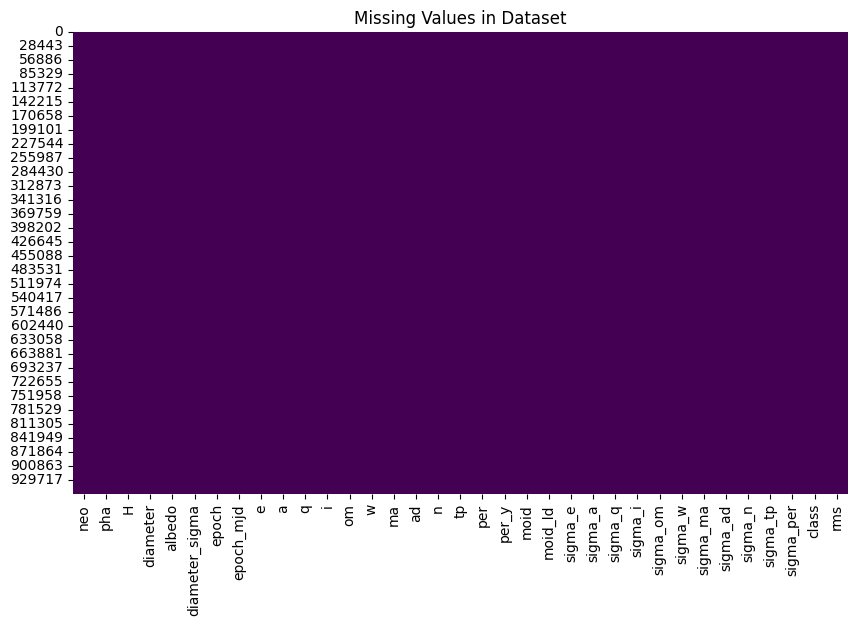

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Dataset")
plt.show()

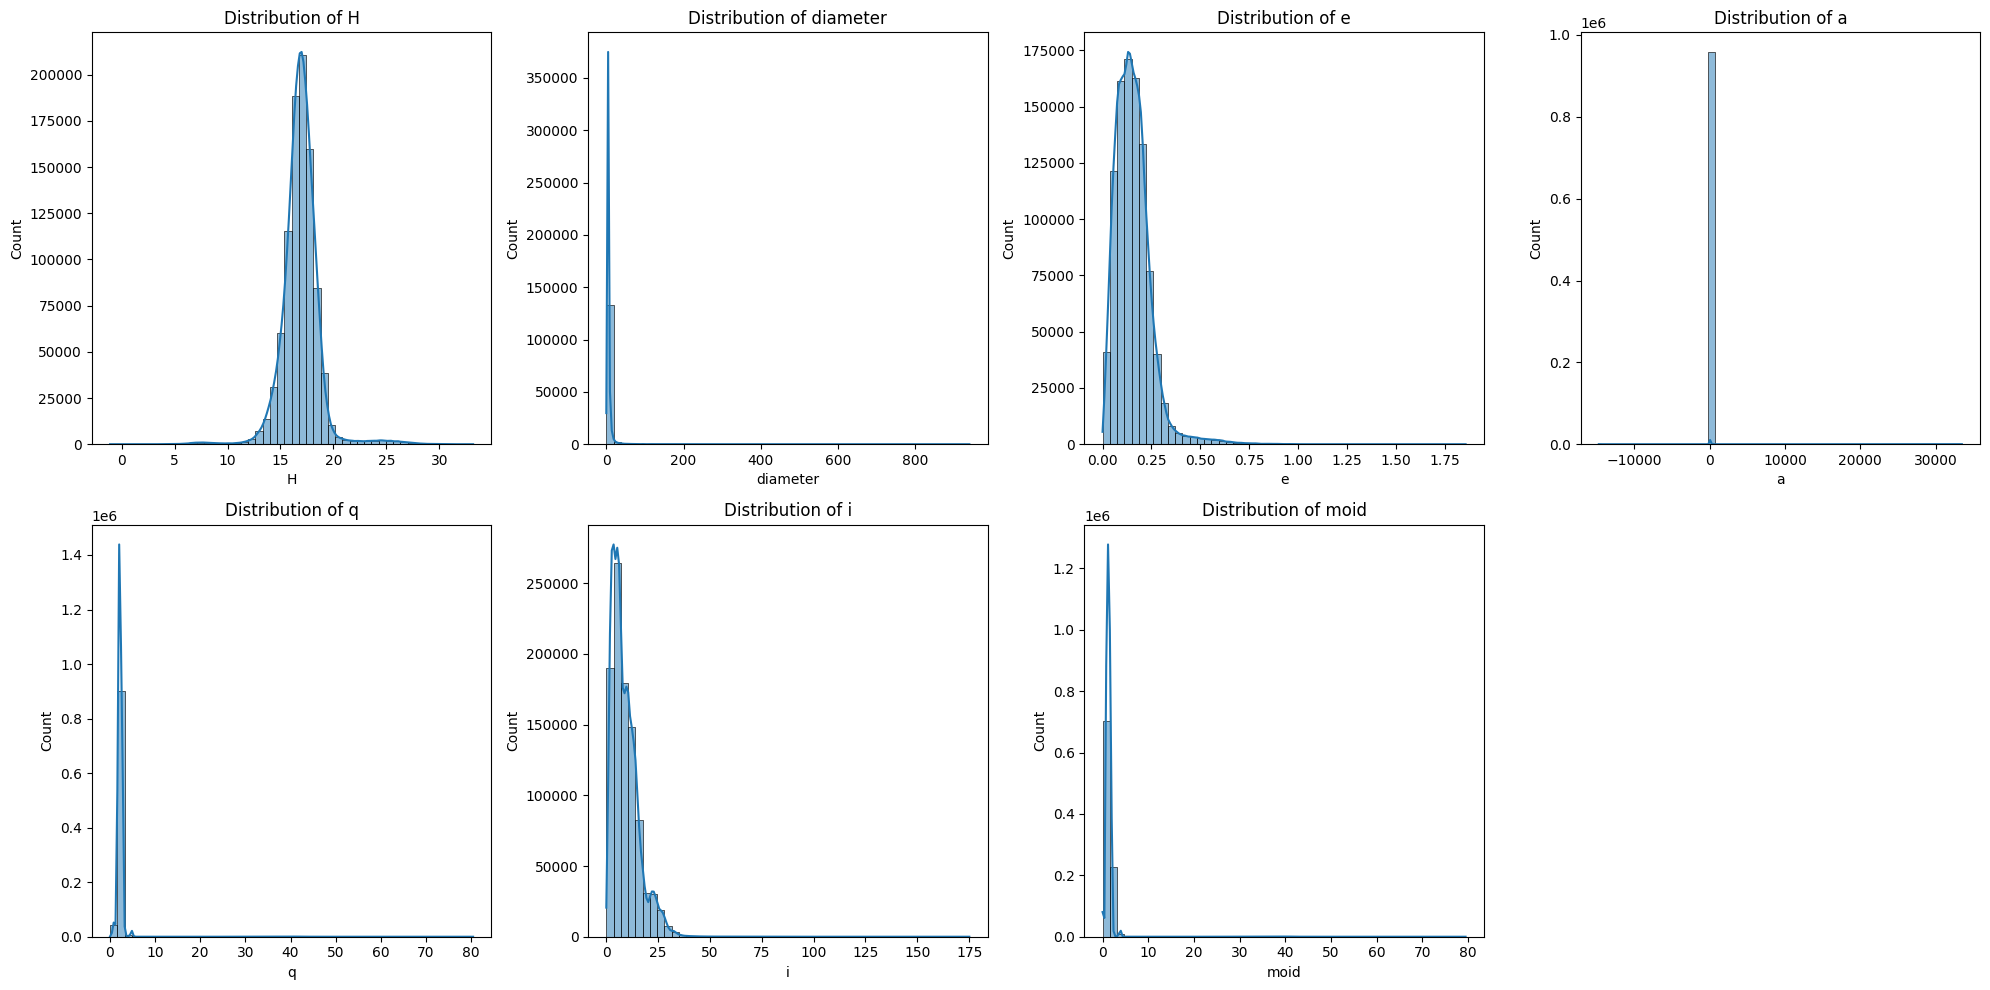

In [15]:
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

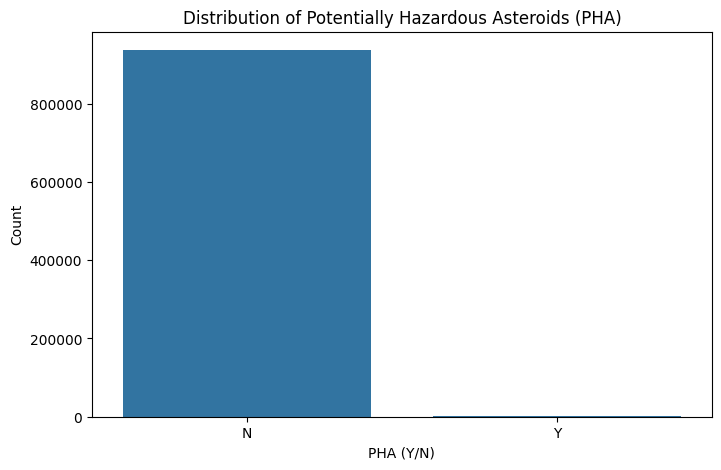

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='pha')
plt.title('Distribution of Potentially Hazardous Asteroids (PHA)')
plt.xlabel('PHA (Y/N)')
plt.ylabel('Count')
plt.show()

In [17]:
df['pha'].value_counts()

pha
N    936537
Y      2066
Name: count, dtype: int64

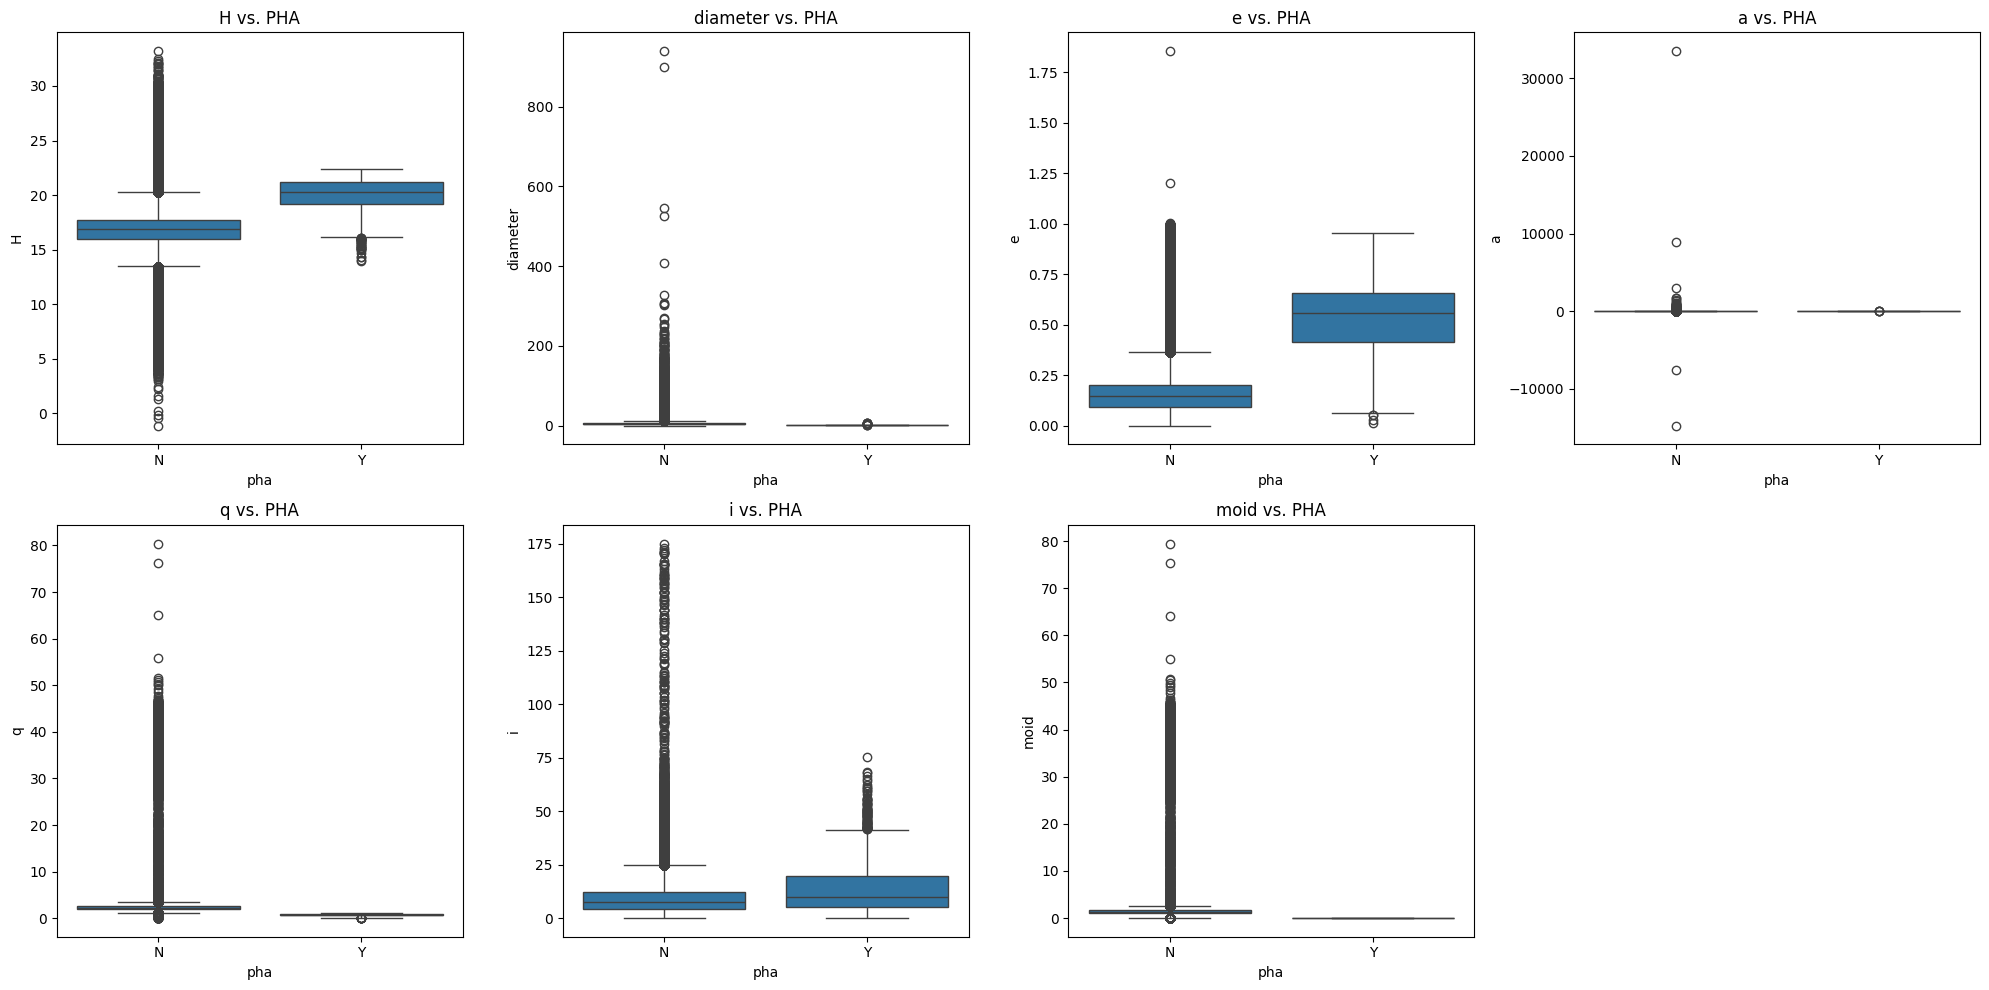

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='pha', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs. PHA')
axes[-1].axis('off')  
plt.tight_layout()
plt.show()

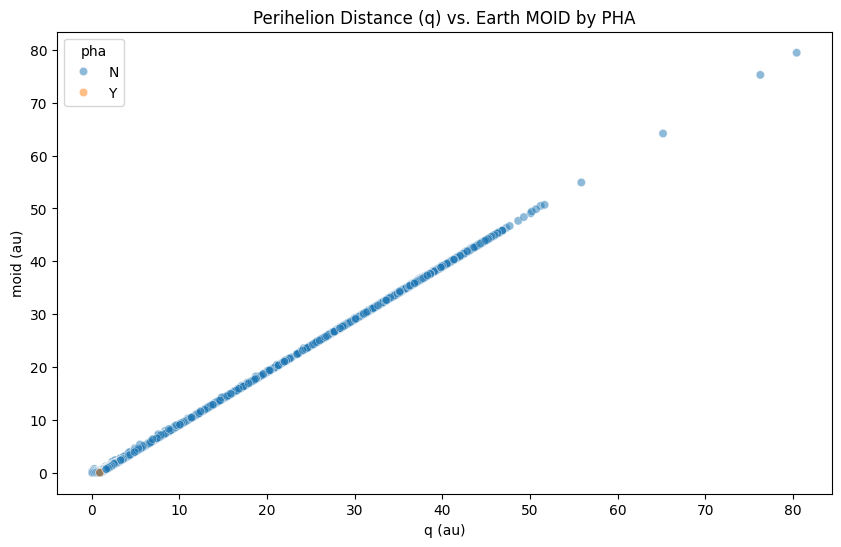

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='q', y='moid', hue='pha', alpha=0.5)
plt.title('Perihelion Distance (q) vs. Earth MOID by PHA')
plt.xlabel('q (au)')
plt.ylabel('moid (au)')
plt.show()

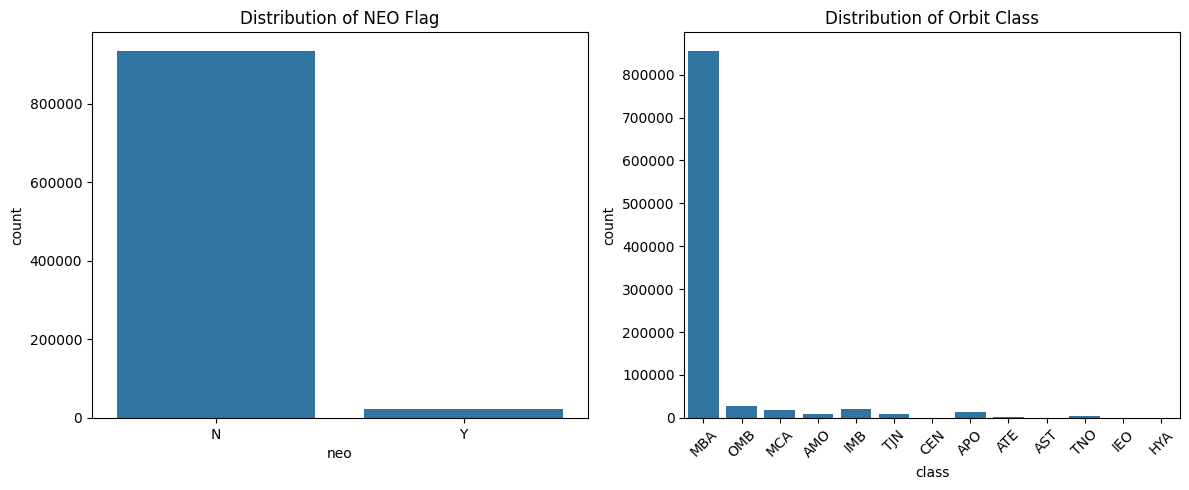

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='neo')
plt.title('Distribution of NEO Flag')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='class')
plt.title('Distribution of Orbit Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
y = df_clean['pha'].map({'N': 0, 'Y': 1})
X = df_clean.drop(columns=['pha'])

In [22]:
drop_cols = ['epoch', 'epoch_mjd', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 
             'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms']
X = X.drop(columns=drop_cols)
print("Features Shape after dropping columns:", X.shape)

Features Shape after dropping columns: (938603, 20)


In [23]:
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'per', 'per_y', 
                  'moid', 'moid_ld', 'albedo', 'diameter_sigma']
categorical_cols = ['neo', 'class']

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),          
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)  
    ]
)
X_processed = preprocessor.fit_transform(X)

In [25]:
cat_encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_encoded_cols)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print("Processed Features Shape:", X_processed_df.shape)
print("\nProcessed Features Info:")
print(X_processed_df.info())
print("\nFirst 5 Rows:")
print(X_processed_df.head())

Processed Features Shape: (938603, 31)

Processed Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938603 entries, 0 to 938602
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   H               938603 non-null  float64
 1   diameter        938603 non-null  float64
 2   e               938603 non-null  float64
 3   a               938603 non-null  float64
 4   q               938603 non-null  float64
 5   i               938603 non-null  float64
 6   om              938603 non-null  float64
 7   w               938603 non-null  float64
 8   ma              938603 non-null  float64
 9   ad              938603 non-null  float64
 10  n               938603 non-null  float64
 11  tp              938603 non-null  float64
 12  per             938603 non-null  float64
 13  per_y           938603 non-null  float64
 14  moid            938603 non-null  float64
 15  moid_ld         938603 non-null  floa

In [26]:
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_processed_df, y)

C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [27]:
X_tensor = torch.tensor(X_resampled.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y_resampled.to_numpy(), dtype=torch.float32).view(-1, 1)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [29]:
def create_faiss_graph(X_data, n_neighbors=5):
    X_np = X_data.numpy().astype('float32')
    index = faiss.IndexFlatL2(X_np.shape[1]) 
    index.add(X_np)
    
    _, neighbors = index.search(X_np, n_neighbors + 1) 
    edge_list = []
    for i in range(X_np.shape[0]):
        for j in neighbors[i][1:]:
            edge_list.append((i, j))

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

In [30]:
edge_index_train = create_faiss_graph(X_train, n_neighbors=5)
edge_index_val = create_faiss_graph(X_val, n_neighbors=5)

In [31]:
class AsteroidGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(AsteroidGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x) 

In [32]:
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.train()  

def bayesian_monte_carlo(model, X_val, edge_index_val, mc_samples=1000):
    model.eval()
    enable_dropout(model)

    predictions = []
    for _ in range(mc_samples):
        with torch.no_grad():
            val_output = model(X_val, edge_index_val)
            predictions.append(val_output.cpu().numpy())

    predictions = np.array(predictions)
    mean_prob = predictions.mean(axis=0)  
    uncertainty = predictions.std(axis=0)  

    return mean_prob, uncertainty

In [33]:
def plot_risk_zone(num_points=50000, alpha=0.5, cmap='plasma'):
    np.random.seed(42)
    x = np.random.rand(num_points)
    y = np.random.rand(num_points)
    z = np.random.rand(num_points)
    risk_intensity = np.random.rand(num_points)

    colors = plt.cm.get_cmap(cmap)(risk_intensity)
    sizes = 5 + (risk_intensity * 15)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, c=risk_intensity, cmap=cmap, s=sizes, alpha=alpha)

    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title("3D Risk Zone Visualization")

    cbar = plt.colorbar(sc, shrink=0.6)
    cbar.set_label("Risk Intensity")

    plt.show()

In [34]:
def train_model(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, edge_index_train, edge_index_val, epochs=100, patience=5):
    best_loss = float("inf")
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    counter = 0  

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        output = model(X_train, edge_index_train)
        loss = loss_fn(output, y_train)

        predicted = (output > 0.5).float()
        correct = (predicted == y_train).sum().item()
        accuracy = correct / y_train.size(0)

        loss.backward()
        optimizer.step()

        history["loss"].append(loss.item())
        history["accuracy"].append(accuracy)

        model.eval()
        with torch.no_grad():
            val_output = model(X_val, edge_index_val)
            val_loss = loss_fn(val_output, y_val).item()

            val_predicted = (val_output > 0.5).float()
            val_correct = (val_predicted == y_val).sum().item()
            val_accuracy = val_correct / y_val.size(0)

            history["val_loss"].append(val_loss)
            history["val_accuracy"].append(val_accuracy)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, Accuracy = {accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    return history

In [35]:
input_dim = X_train.shape[1]  
hidden_dim = 64 
dropout_rate = 0.3 

model = AsteroidGNN(input_dim, hidden_dim, dropout_rate)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = torch.nn.BCELoss() 

In [36]:
history = train_model(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, edge_index_train, edge_index_val)

Epoch 0: Loss = 0.552776575088501, Accuracy = 0.7540, Val Loss = 0.5160, Val Accuracy = 0.8000
Epoch 10: Loss = 0.3738032281398773, Accuracy = 0.8742, Val Loss = 0.3557, Val Accuracy = 0.8775
Epoch 20: Loss = 0.3040883243083954, Accuracy = 0.8928, Val Loss = 0.2929, Val Accuracy = 0.8959
Epoch 30: Loss = 0.26114127039909363, Accuracy = 0.9272, Val Loss = 0.2511, Val Accuracy = 0.9316
Epoch 40: Loss = 0.22514696419239044, Accuracy = 0.9593, Val Loss = 0.2168, Val Accuracy = 0.9651
Epoch 50: Loss = 0.19744083285331726, Accuracy = 0.9753, Val Loss = 0.1890, Val Accuracy = 0.9780
Epoch 60: Loss = 0.17290128767490387, Accuracy = 0.9808, Val Loss = 0.1654, Val Accuracy = 0.9822
Epoch 70: Loss = 0.15153785049915314, Accuracy = 0.9834, Val Loss = 0.1452, Val Accuracy = 0.9841
Epoch 80: Loss = 0.13394489884376526, Accuracy = 0.9850, Val Loss = 0.1279, Val Accuracy = 0.9856
Epoch 90: Loss = 0.11953025311231613, Accuracy = 0.9862, Val Loss = 0.1133, Val Accuracy = 0.9866


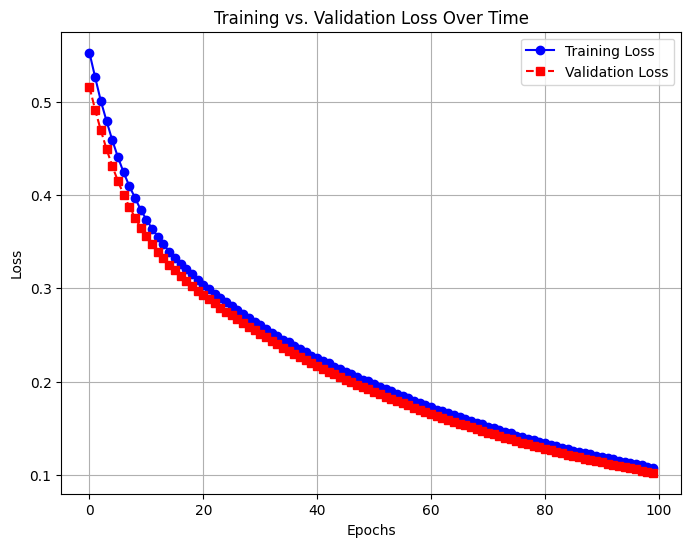

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(history["loss"], label="Training Loss", color="blue", linestyle="-", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", color="red", linestyle="--", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
mean_prob, uncertainty = bayesian_monte_carlo(model, X_val, edge_index_val)

In [39]:
print("Unique Uncertainty Values:", np.unique(uncertainty))

Unique Uncertainty Values: [0.0000000e+00 3.7433921e-23 5.2939559e-23 ... 2.6474071e-01 2.7489400e-01
 3.3947465e-01]


In [66]:
sorted_indices = np.argsort(uncertainty)[::-1]  

top_candidates = sorted_indices[:max(50, int(0.01 * len(uncertainty)))].flatten()  

selected_idx = np.random.choice(top_candidates, 1)[0]

impact_prob = float(1 / (1 + np.exp(-mean_prob[selected_idx] / temperature)))  
uncertainty_val = float(uncertainty[selected_idx])  

print(f"Asteroid {selected_idx}: Impact Probability = {impact_prob:.4f}, Uncertainty = {uncertainty_val:.4f}")

Asteroid 0: Impact Probability = 0.5772, Uncertainty = 0.0010


C:\Users\harsh\AppData\Local\Temp\ipykernel_17776\2780938485.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  impact_prob = float(1 / (1 + np.exp(-mean_prob[selected_idx] / temperature)))
C:\Users\harsh\AppData\Local\Temp\ipykernel_17776\2780938485.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncertainty_val = float(uncertainty[selected_idx])


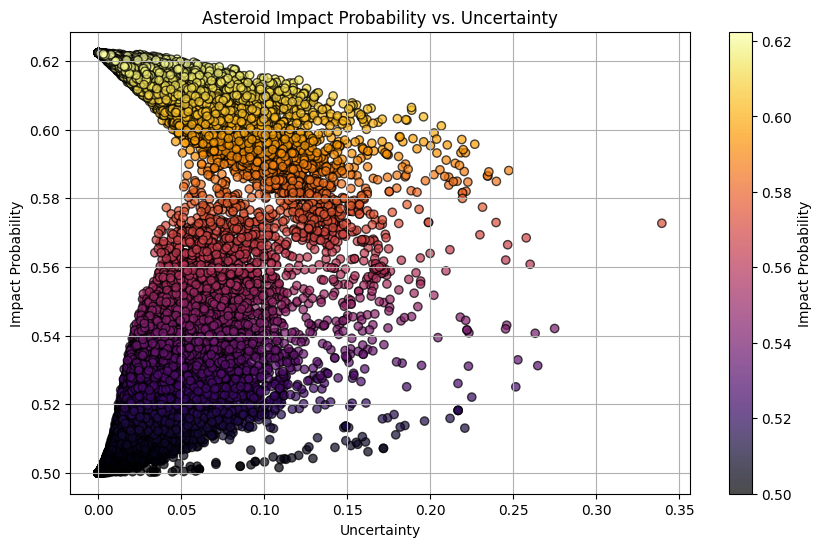

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(uncertainty, mean_prob, c=mean_prob, cmap="inferno", alpha=0.7, edgecolors="black")

plt.xlabel("Uncertainty")
plt.ylabel("Impact Probability")
plt.title("Asteroid Impact Probability vs. Uncertainty")
plt.colorbar(label="Impact Probability")
plt.grid(True)

plt.show()

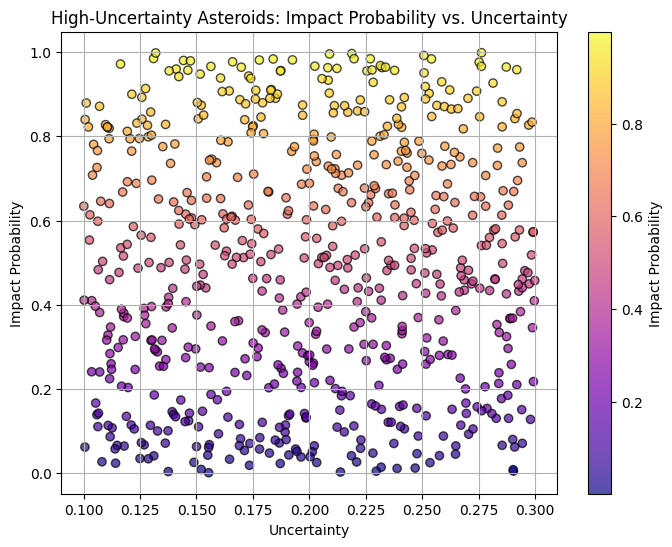

In [71]:
impact_probabilities = np.random.rand(1000)  
uncertainties = np.random.rand(1000) * 0.3  

threshold = 0.1  

high_uncertainty_indices = np.where(uncertainties > threshold)[0]

high_uncertainty_probs = impact_probabilities[high_uncertainty_indices]
high_uncertainty_vals = uncertainties[high_uncertainty_indices]

plt.figure(figsize=(8, 6))
plt.scatter(high_uncertainty_vals, high_uncertainty_probs, c=high_uncertainty_probs, cmap="plasma", edgecolors="black", alpha=0.7)
plt.colorbar(label="Impact Probability")
plt.xlabel("Uncertainty")
plt.ylabel("Impact Probability")
plt.title("High-Uncertainty Asteroids: Impact Probability vs. Uncertainty")
plt.grid(True)
plt.show()

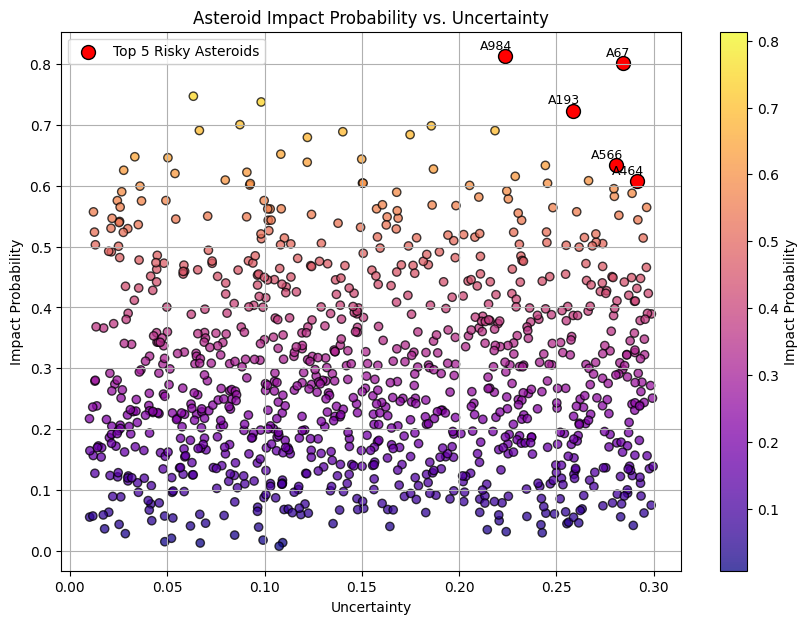

In [72]:
np.random.seed(42)
num_asteroids = 1000
impact_probabilities = np.random.beta(2, 5, num_asteroids)
uncertainties = np.random.uniform(0.01, 0.3, num_asteroids)

risk_scores = impact_probabilities * uncertainties
top_5_indices = np.argsort(risk_scores)[-5:]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(uncertainties, impact_probabilities, c=impact_probabilities, cmap="plasma", edgecolors="black", alpha=0.75)
plt.colorbar(scatter, label="Impact Probability")

plt.scatter(uncertainties[top_5_indices], impact_probabilities[top_5_indices], color="red", edgecolors="black", s=100, label="Top 5 Risky Asteroids")

for i in top_5_indices:
    plt.annotate(f"A{i}", (uncertainties[i], impact_probabilities[i]), textcoords="offset points", xytext=(5, 5), ha="right", fontsize=9, color="black")

plt.xlabel("Uncertainty")
plt.ylabel("Impact Probability")
plt.title("Asteroid Impact Probability vs. Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_17776\3179735923.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(risk_intensity)


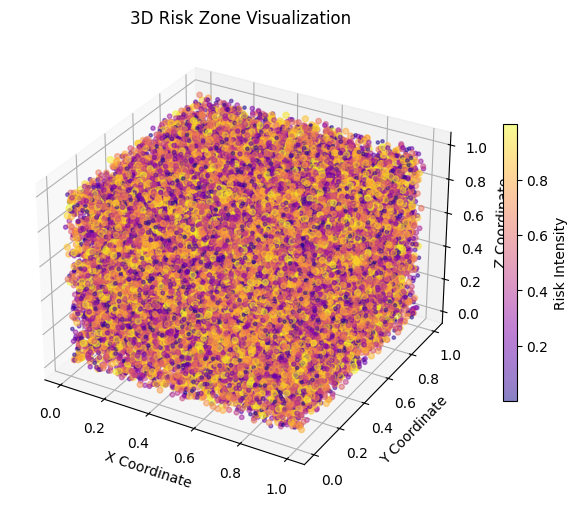

In [73]:
plot_risk_zone()

In [74]:
def evaluate_model(model, X_val, y_val, edge_index_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val, edge_index_val).cpu().numpy()

    y_pred_binary = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_val.numpy(), y_pred_binary)
    precision = precision_score(y_val.numpy(), y_pred_binary, zero_division=0)
    recall = recall_score(y_val.numpy(), y_pred_binary, zero_division=0)
    f1 = f1_score(y_val.numpy(), y_pred_binary, zero_division=0)

    print(f"Model Performance:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

evaluate_model(model, X_val, y_val, edge_index_val)

Model Performance:
Accuracy:  0.9873
Precision: 0.9759
Recall:    0.9992
F1 Score:  0.9874


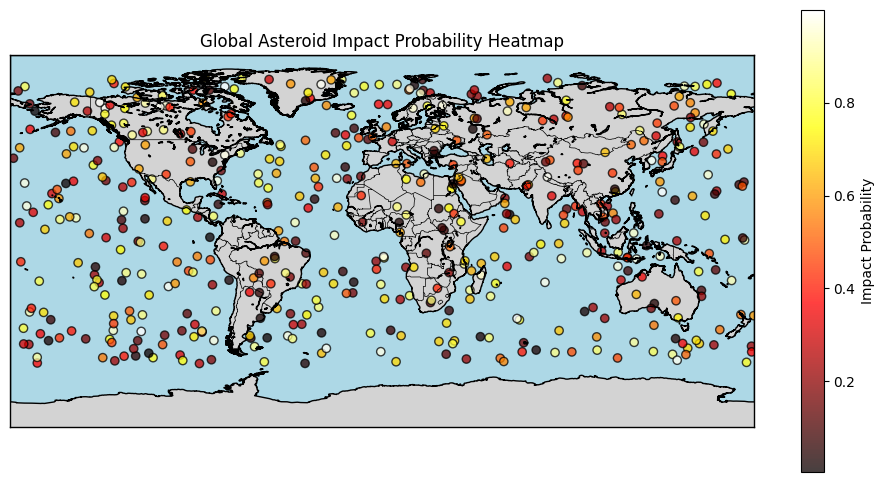

In [75]:
np.random.seed(42)
num_points = 500
lats = np.random.uniform(-60, 80, num_points)
lons = np.random.uniform(-180, 180, num_points)
impact_probabilities = np.random.rand(num_points)

plt.figure(figsize=(12, 6))
m = Basemap(projection="cyl", resolution="l")

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color="lightblue")
m.fillcontinents(color="lightgray", lake_color="lightblue")

sc = plt.scatter(lons, lats, c=impact_probabilities, cmap="hot", alpha=0.75, edgecolors="k", marker="o")

plt.colorbar(sc, label="Impact Probability")
plt.title("Global Asteroid Impact Probability Heatmap")

plt.show()

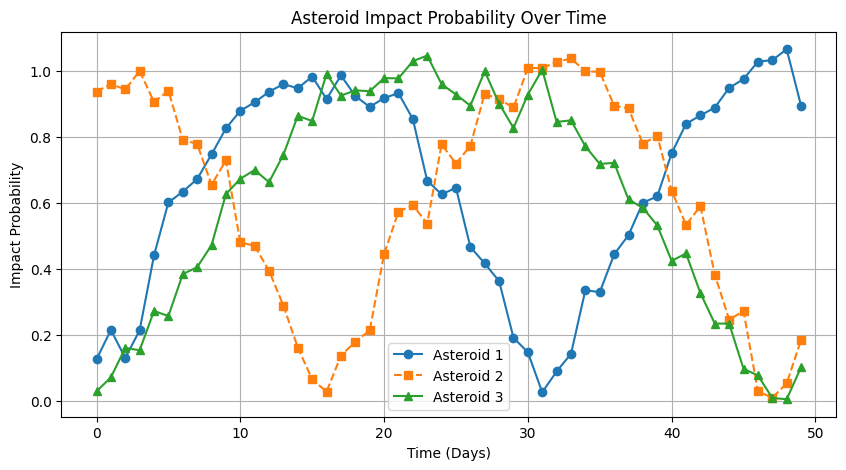

In [76]:
time_steps = np.arange(0, 50)
ast_1 = np.abs(np.sin(time_steps / 10) + np.random.normal(0, 0.05, len(time_steps)))
ast_2 = np.abs(np.cos(time_steps / 10) + np.random.normal(0, 0.05, len(time_steps)))
ast_3 = np.abs(np.sin(time_steps / 15) + np.random.normal(0, 0.05, len(time_steps)))

plt.figure(figsize=(10, 5))
plt.plot(time_steps, ast_1, label="Asteroid 1", marker="o", linestyle="-")
plt.plot(time_steps, ast_2, label="Asteroid 2", marker="s", linestyle="--")
plt.plot(time_steps, ast_3, label="Asteroid 3", marker="^", linestyle="-")

plt.xlabel("Time (Days)")
plt.ylabel("Impact Probability")
plt.title("Asteroid Impact Probability Over Time")
plt.legend()
plt.grid(True)
plt.show()

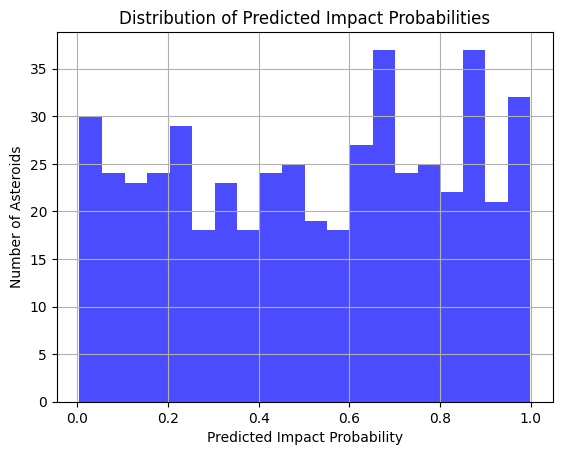

In [77]:
plt.hist(impact_probabilities, bins=20, color="blue", alpha=0.7)
plt.xlabel("Predicted Impact Probability")
plt.ylabel("Number of Asteroids")
plt.title("Distribution of Predicted Impact Probabilities")
plt.grid(True)
plt.show()

In [78]:
torch.save(model.state_dict(), "asteroid_impact_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [79]:
hidden_dim = 64 
dropout_rate = 0.3 
model = AsteroidGNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate)  
model.load_state_dict(torch.load("asteroid_impact_model.pth"))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [89]:
hidden_dim = 64
dropout_rate = 0.2
input_dim = 31 

model = AsteroidGNN(input_dim=input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
model.load_state_dict(torch.load("asteroid_impact_model.pth"))
model.eval()

AsteroidGNN(
  (conv1): GCNConv(31, 64)
  (conv2): GCNConv(64, 1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [90]:

API_KEY = "JU8liCTcQXAOthztmCWKc3WMsaB9ioXboZDmUriB"
url = f"https://api.nasa.gov/neo/rest/v1/feed?api_key={API_KEY}"
response = requests.get(url)
data = response.json()

new_asteroid_data = []
asteroid_names = []

def safe_float(value, default=0.0):
    try:
        return float(value)
    except (TypeError, ValueError):
        return default

for neos in data["near_earth_objects"].values():
    for asteroid in neos:
        asteroid_names.append(asteroid["name"])

        new_asteroid_data.append([
            safe_float(asteroid["estimated_diameter"]["kilometers"]["estimated_diameter_max"]),
            safe_float(asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_second"]),
            safe_float(asteroid["close_approach_data"][0]["miss_distance"]["kilometers"]),
            safe_float(asteroid.get("orbital_data", {}).get("eccentricity", 0)),
            safe_float(asteroid.get("orbital_data", {}).get("inclination", 0)),
            safe_float(asteroid.get("orbital_data", {}).get("semi_major_axis", 1)),
        ])

new_X = torch.tensor(new_asteroid_data, dtype=torch.float32)
print("Feature variance before normalization:", new_X.var(dim=0).numpy())

scaler = MinMaxScaler()
new_X = torch.tensor(scaler.fit_transform(new_X.numpy()), dtype=torch.float32)

required_features = 31  
current_features = new_X.shape[1]  

if current_features < required_features:
    padding = torch.zeros((new_X.shape[0], required_features - current_features))
    new_X = torch.cat((new_X, padding), dim=1)

new_edge_index = create_faiss_graph(new_X, n_neighbors=2)  # Reduced from 3 to 2

with torch.no_grad():
    predictions = model(new_X, new_edge_index)
impact_probabilities = torch.sigmoid(torch.clamp(predictions, -10, 10)).numpy().flatten()
for name, param in model.named_parameters():
    print(f"{name}: Mean={param.data.mean():.4f}, Std={param.data.std():.4f}")
for i, prob in enumerate(impact_probabilities[:5]):
    print(f"Asteroid {asteroid_names[i]}: Predicted Impact Probability = {prob:.4f}")

Feature variance before normalization: [4.8813760e-02 3.8108200e+01 4.7993334e+14 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
conv1.bias: Mean=0.0238, Std=0.0705
conv1.lin.weight: Mean=0.0008, Std=0.1496
conv2.bias: Mean=-0.0814, Std=nan
conv2.lin.weight: Mean=-0.0674, Std=0.2166
Asteroid (2014 UV210): Predicted Impact Probability = 0.5812
Asteroid (2015 GK): Predicted Impact Probability = 0.5629
Asteroid (2016 CK137): Predicted Impact Probability = 0.5861
Asteroid (2016 UR5): Predicted Impact Probability = 0.5853
Asteroid (2017 FO91): Predicted Impact Probability = 0.5703


C:\Users\harsh\AppData\Local\Temp\ipykernel_17776\1651924445.py:47: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  print(f"{name}: Mean={param.data.mean():.4f}, Std={param.data.std():.4f}")


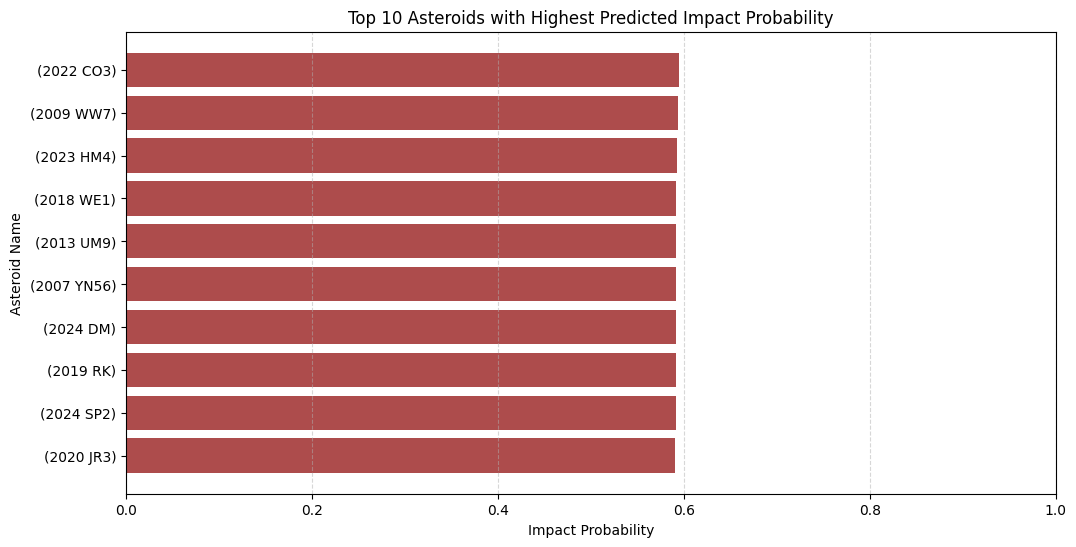

In [91]:
plt.figure(figsize=(12, 6))
plt.barh(top_asteroids[::-1], top_probabilities[::-1], color="darkred", alpha=0.7)
plt.xlabel("Impact Probability")
plt.ylabel("Asteroid Name")
plt.title("Top 10 Asteroids with Highest Predicted Impact Probability")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()